In [ ]:
# 1.1: Install & import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder



# ===============================================
# 📌 Section 1: String Manipulations
# ===============================================

In [ ]:


# Loading a Sample Pandas DataFrame
import pandas as pd

df = pd.DataFrame.from_dict({
    'Name': ['Sally, Johnson', 'Ahmed, Tariq', 'Tariq, Ahmed', ' Johnson, Sally ', ' sally,  Johnson', 'Ahmed,Tariq'],
    'City': ['new york', ' TORONTO', 'Toronto ', 'New  York', 'london', ' TORONTO'],
    'Favorite Color': ['  Blue', 'green  ', ' RED ', 'Blue', ' Green', 'Green'],
    'Date Joined': ['2023-01-01', '2023-03-15', '2023-03-15', '2023-01-01', '2023-03-15', '2023-03-15']
})

df


In [ ]:
print(df)

In [ ]:
# Strip leading/trailing spaces
df['Name'] = df['Name'].str.strip()
df['City'] = df['City'].str.strip()
df['Favorite Color'] = df['Favorite Color'].str.strip()

print(df)

In [ ]:
# Normalize spacing inside strings (e.g., "New  York")
df['Name'] = df['Name'].str.replace(r'\s+', ' ', regex=True)
df['City'] = df['City'].str.replace(r'\s+', ' ', regex=True)

print(df)

In [ ]:
# Standardize text casing
df['Name'] = df['Name'].str.title()
df['City'] = df['City'].str.title()
df['Favorite Color'] = df['Favorite Color'].str.capitalize()

print(df)

In [ ]:
# Split and reformat names to First Last format
df[['Last Name', 'First Name']] = df['Name'].str.split(',', expand=True)
df['First Name'] = df['First Name'].str.strip().str.title()
df['Last Name'] = df['Last Name'].str.strip().str.title()

print(df)

In [ ]:
df['Name'] = df['First Name'] + ' ' + df['Last Name']

# Drop temporary columns
df.drop(columns=['First Name', 'Last Name'], inplace=True)

print(df)

In [ ]:

print(df.duplicated())

In [ ]:
print(df.duplicated().sum())

In [ ]:
df_clean = df.drop_duplicates()
print(df_clean)

# ===============================================
# 📌 Section 2: Feature Engineering
# ===============================================

In [ ]:
df = pd.DataFrame.from_dict({
    'Name': ['Jane', 'Melissa', 'John', 'Matt', 'Ali', 'Aisha'],
    'Age': [23, 45, 35, 64, 19, 60],
    'Birth City': ['London', 'Paris', 'Toronto', 'Atlanta', 'Istanbul', 'Cairo'],
    'Gender': ['F', 'F', 'M', 'M', 'M', 'F']
})

print("# Step 1: Original DataFrame")
print(df)

In [ ]:
df.info()

In [ ]:
# Step 2: Basic age categorization
#We use Pandas `.loc` to apply conditional logic:
df['Age Category'] = 'Over 30'
df.loc[df['Age'] < 30, 'Age Category'] = 'Under 30'


print(df)

In [ ]:
print(df["Age"].dtype)

In [ ]:
# Step 3: Use np.select to bucket ages into ranges
conditions = [
    (df['Age'] < 20),
    (df['Age'] >= 20) & (df['Age'] < 40),
    (df['Age'] >= 40) & (df['Age'] < 60),
    (df['Age'] >= 60)
]

values = ['<20 years old', '20–39 years old', '40–59 years old', '60+ years old']

df['Age Group'] = np.select(conditions, values, default='Unknown')


print(df)

In [ ]:
# Step 4: Map city to country using .map
#We map each birth city to its corresponding country using a dictionary.
#.map()` is ideal when you have a predefined mapping for a categorical feature.
city_dict = {
    'Paris': 'France',
    'Toronto': 'Canada',
    'Atlanta': 'USA',
    'Istanbul': 'Turkey',
    'Cairo': 'Egypt'
}

df['Country'] = df['Birth City'].map(city_dict)
df['Country'] = df['Country'].fillna('Other')  # handle unmapped cities


print(df)

In [ ]:
# Step 5.1: Add name length
#Name Length: number of characters in the `Name` column
df['Name Length'] = df['Name'].apply(len)

# Step 5.2: Add square root of age
#Age Sqrt: square root of the person's age
df['Age Sqrt'] = df['Age'].apply(np.sqrt)

print(df)

# ===============================================
# 📌 Section 3: Missing Value & Outlier Detection
# ===============================================

In [ ]:
# 1.2: Load Titanic dataset
titanic = sns.load_dataset("titanic")  # Alternative: pd.read_csv(...)
df = titanic.copy()

# 1.3: Quick look
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 📘 Types of Missing Data: MCAR, MAR, MNAR

Not all missingness is the same:

- **MCAR (Missing Completely at Random)**: Missingness is unrelated to other variables.
- **MAR (Missing at Random)**: Missingness is related to observed variables.
- **MNAR (Missing Not at Random)**: Missingness is related to the value itself (e.g., high-income respondents skipping income).

We can't always test this formally, but visualization helps!

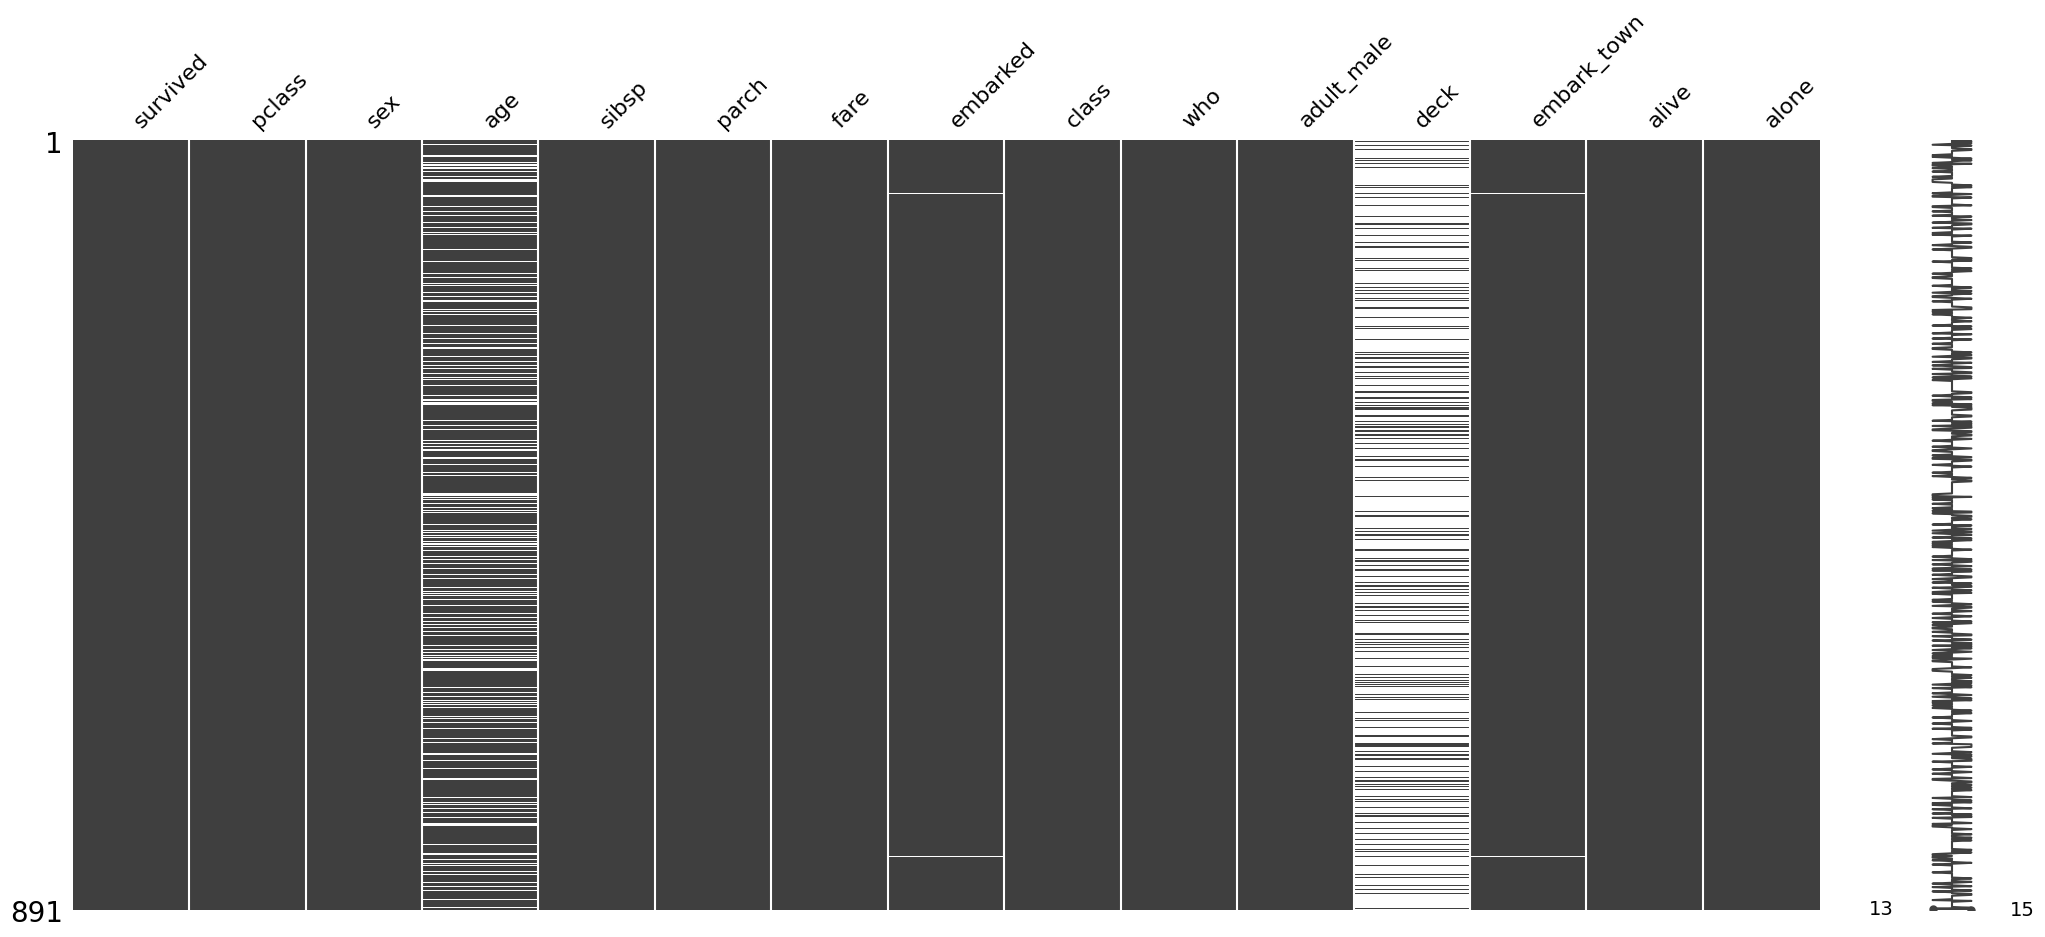

In [ ]:
# 2.1: Summary of missing values
df.isnull().sum().sort_values(ascending=False)

# 2.2: Visualize missingness
import missingno as msno
msno.matrix(df)
plt.show()


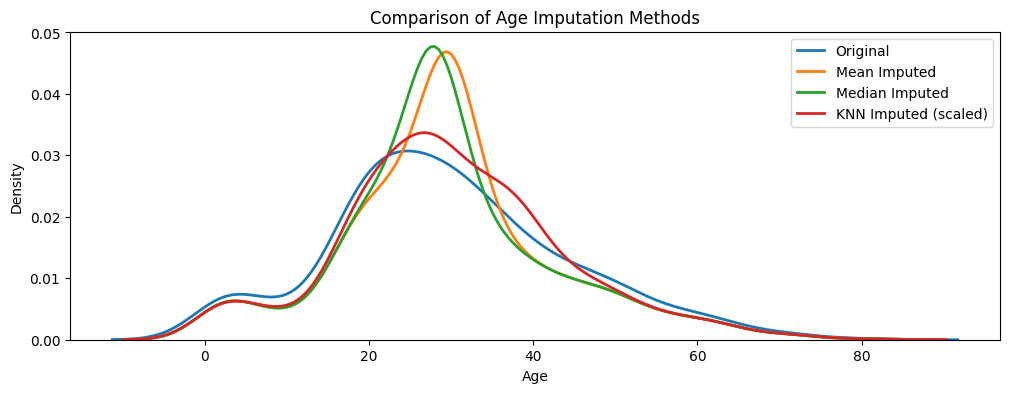

In [ ]:
# 3.1: Select subset of features to demonstrate
subset = df[["age", "embarked", "deck", "fare"]]

# 3.2: Mean and median imputation
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

subset_mean = subset.copy()
subset_mean["age"] = mean_imputer.fit_transform(subset[["age"]])

subset_median = subset.copy()
subset_median["age"] = median_imputer.fit_transform(subset[["age"]])

# 3.3: KNN Imputation — scaling is essential!
knn_data = subset[["age", "fare"]].copy()  # Only numeric features for distance calc

# Step 1: Scale numeric features
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)

# Step 2: Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed_scaled = knn_imputer.fit_transform(knn_data_scaled)

# Step 3: Inverse scale back to original range
knn_imputed = scaler.inverse_transform(knn_imputed_scaled)
subset_knn = pd.DataFrame(knn_imputed, columns=["age", "fare"])

# 3.4: KDE Plot Comparison of 'age'
plt.figure(figsize=(12, 4))
sns.kdeplot(subset["age"], label="Original", lw=2)
sns.kdeplot(subset_mean["age"], label="Mean Imputed", lw=2)
sns.kdeplot(subset_median["age"], label="Median Imputed", lw=2)
sns.kdeplot(subset_knn["age"], label="KNN Imputed (scaled)", lw=2)
plt.legend()
plt.title("Comparison of Age Imputation Methods")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()


## 🤖 K-Nearest Neighbors (KNN) Imputer: Explained

KNN Imputation is a **non-parametric, instance-based imputation method** that fills in missing values by considering the *similarity* between observations.

### 🔍 How It Works:
1. For each observation with missing data, KNN finds the **k most similar rows** (neighbors) using a distance metric (e.g., Euclidean distance).
2. The missing value is **imputed based on the values in the nearest neighbors**.
   - For numerical columns → mean (or weighted average) of neighbors.
   - For categorical columns → most frequent value.

### ✅ Advantages:
- Captures multivariate relationships.
- Adapts to complex data patterns better than mean/median.
- No assumptions about data distribution.

### ⚠️ Limitations:
- Computationally expensive for large datasets.
- Sensitive to irrelevant or unscaled features.
- Needs complete rows to compute distances (i.e., not good when most data is missing).

### 🧠 Best Practice:
- Apply **scaling before KNN imputation**, as it relies on distance measures.


In [ ]:
# Plotting boxplots to spot outliers
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df["fare"])
plt.title("Fare Distribution (Boxplot)")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["age"])
plt.title("Age Distribution (Boxplot)")
plt.show()


In [ ]:
# Detecting outliers in "fare" using IQR
Q1 = df["fare"].quantile(0.25)
Q3 = df["fare"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["fare"] < lower_bound) | (df["fare"] > upper_bound)]
print(f"Number of outliers in fare: {len(outliers)}")


In [ ]:
# Optionally cap (winsorize) fare values at bounds
df["fare_capped"] = df["fare"].clip(lower=lower_bound, upper=upper_bound)

# Plot before and after
plt.figure(figsize=(10, 4))
sns.kdeplot(df["fare"], label="Original", lw=2)
sns.kdeplot(df["fare_capped"], label="Capped", lw=2)
plt.legend()
plt.title("Fare Distribution Before and After Capping")
plt.show()


# ===============================================
# 📌 Section 4: Encoding
# ===============================================

In [ ]:
# Identify categorical variables
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(cat_cols)

# View unique values
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")


In [ ]:
# Drop rows with missing 'embarked' to simplify encoding for now
df_enc = df.dropna(subset=["embarked", "sex", "class"]).copy()

# Define features
X = df_enc[["sex", "embarked", "class", "fare", "age"]]
y = df_enc["survived"]

# Define categorical and numeric columns
cat_features = ["sex", "embarked", "class"]
num_features = ["fare", "age"]

# Build ColumnTransformer with OneHotEncoder for categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_features),
    ("num", "passthrough", num_features)
])


In [ ]:
# Fit-transform the data
X_transformed = preprocessor.fit_transform(X)

# Convert to DataFrame
encoded_columns = (
    preprocessor.named_transformers_["cat"]
    .get_feature_names_out(cat_features)
    .tolist()
    + num_features
)

X_encoded = pd.DataFrame(X_transformed, columns=encoded_columns)
X_encoded.head()


# ===============================================
# 📌 Section 5: Scaling
# ===============================================

In [ ]:
# Extract numeric features
X_num = df[["fare", "age"]].dropna()

# Initialize scalers
scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler()
}

# Create scaled DataFrames
scaled_data = {}

for name, scaler in scalers.items():
    scaled = scaler.fit_transform(X_num)
    scaled_data[name] = pd.DataFrame(scaled, columns=["fare", "age"])


In [ ]:
# Plot histograms of 'fare' after different scalings
plt.figure(figsize=(12, 6))

for i, (name, df_scaled) in enumerate(scaled_data.items(), 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(df_scaled["fare"], label="fare")
    plt.title(f"{name} Scaler (Fare)")
    plt.tight_layout()

plt.show()
